In [1]:
import os
import numpy as np
import pydicom
import cv2 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve


ImportError: Traceback (most recent call last):
  File "C:\Users\suppa\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [2]:
#load
TB_DIR = r"C:\Users\suppa\Downloads\TB classification CNN project\intbtr254"
NON_TB_DIR = r"C:\Users\suppa\Downloads\TB classification CNN project\intbtr48"
IMG_SIZE = 224

In [3]:
#Load DICOM Images
def dcm(folder_path,label):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        file_path=os.path.join(folder_path,filename)
        
        try:
            dicom_image=pydicom.dcmread(file_path)
            img_array=dicom_image.pixel_array  
            
            img_resized=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
            img_resized=img_resized / 255.0 

            img_final =np.stack([img_resized] *3,axis=-1)
            
            images.append(img_final)
            labels.append(label)
        
        except Exception as e:
            print(f"Skipping file {filename}:{e}")

    return np.array(images), np.array(labels)

In [4]:
#Load Data
X_tb, y_tb=dcm(TB_DIR,label=1)  
X_non_tb, y_non_tb=dcm(NON_TB_DIR,label=0)

In [5]:
#Combine datasets
X =np.concatenate((X_tb,X_non_tb), axis=0)
y=np.concatenate((y_tb,y_non_tb),axis=0)

In [6]:

print(f'Total images loaded: {len(X)}, Labels: {len(y)}')

Total images loaded: 359, Labels: 359


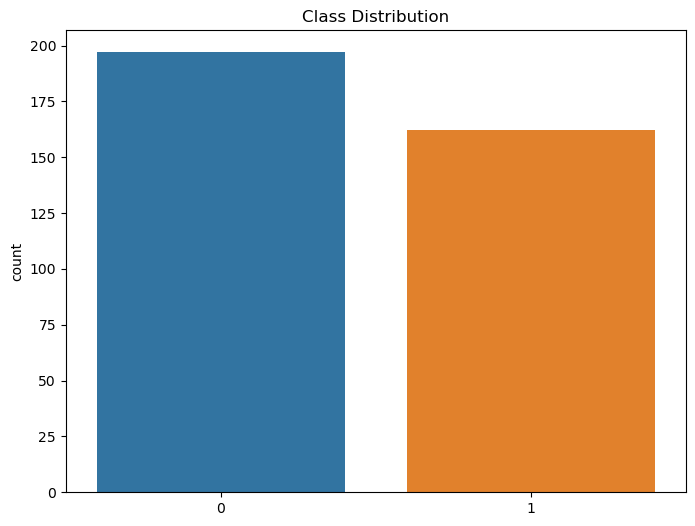

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

In [8]:
#Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)
print(f'Train set:{len(X_train)},Test set:{len(X_test)}')

Train set:287,Test set:72


In [9]:
#Model
model =Sequential([
    layers.Conv2D(32,(3,3), activation="relu",input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    

    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(1,activation='sigmoid') 
])

c:\Users\suppa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
#Compile Model
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stop =EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)

In [13]:
#Train Model
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test),batch_size=32,callbacks=[early_stop])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5451 - loss: 10.7400 - val_accuracy: 0.5556 - val_loss: 0.7460
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 855ms/step - accuracy: 0.6095 - loss: 0.8131 - val_accuracy: 0.8472 - val_loss: 0.4018
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 788ms/step - accuracy: 0.8223 - loss: 0.3533 - val_accuracy: 0.9722 - val_loss: 0.0593
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 767ms/step - accuracy: 0.9630 - loss: 0.0921 - val_accuracy: 0.9861 - val_loss: 0.0262
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 884ms/step - accuracy: 0.9728 - loss: 0.0823 - val_accuracy: 0.9306 - val_loss: 0.1559
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 793ms/step - accuracy: 0.9962 - loss: 0.0270 - val_accuracy: 0.9861 - val_loss: 0.0390
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 990ms/step - accuracy: 0.9931 - loss: 0.0138 - val_accuracy: 0.9722 - val_loss: 0.1555


In [35]:

model.save('tb_classification_model.keras')

In [36]:

test_loss,test_acc=model.evaluate(X_test, y_test)
print(f"Test Accuracy:{test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9931 - loss: 0.0178
Test Accuracy:0.9861


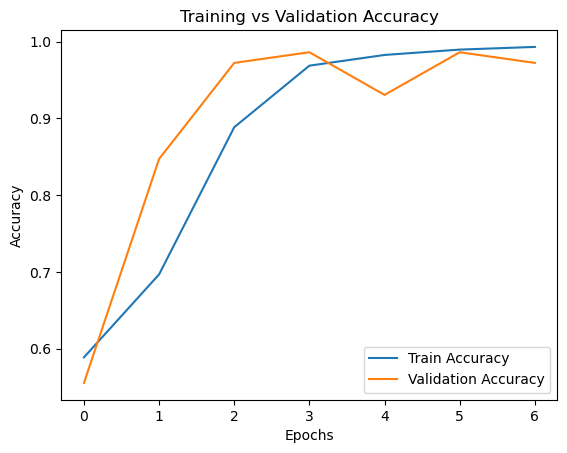

In [16]:

plt.plot(history.history["accuracy"],label="Train Accuracy")
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

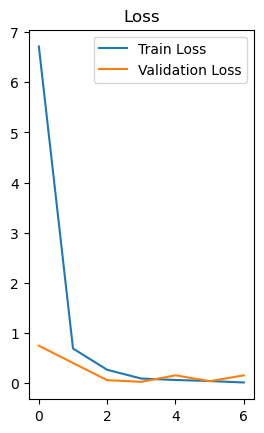

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


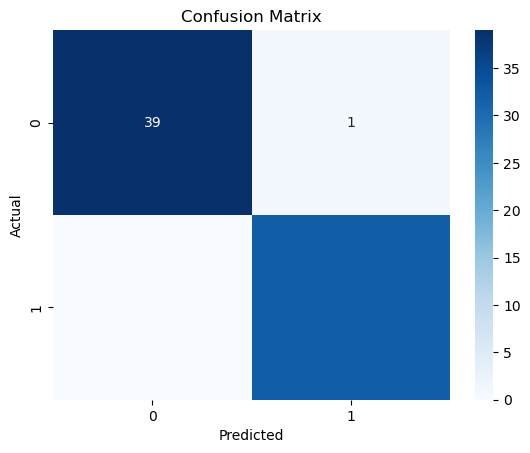

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
predictions=(model.predict(X_test)>0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


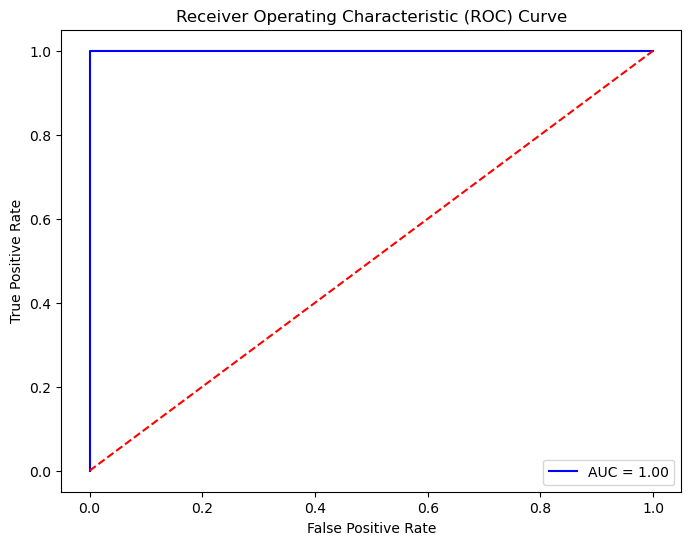

In [26]:
from sklearn.metrics import roc_curve, auc  # ✅ Import these
import matplotlib.pyplot as plt

# Ensure predictions are 1D
y_scores = model.predict(X_test).ravel()

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


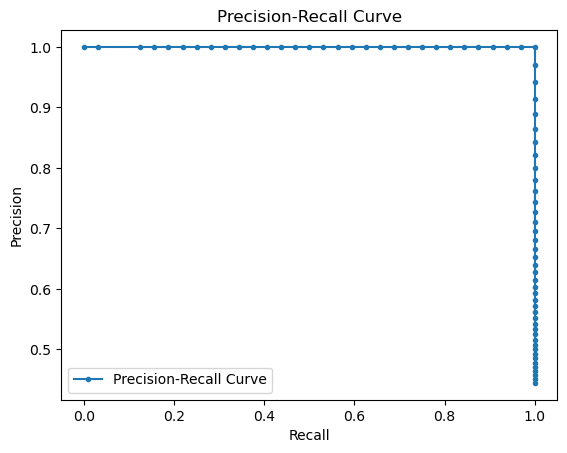

In [22]:
precision, recall, _ =precision_recall_curve(y_test, model.predict(X_test))
plt.plot(recall,precision, marker='.',label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [ ]:
# Classification Report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        40
           1       0.97      1.00      0.98        32

    accuracy                           0.99        72
   macro avg       0.98      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



In [27]:
def pre_image(image_path, model):
   
    try:
        dicom_image =pydicom.dcmread(image_path)
        img = dicom_image.pixel_array
    except Exception as e:
        raise ValueError(f"Error reading DICOM file:{e}")

    img =img.astype(np.float32) / np.max(img)

    if len(img.shape) ==2: 
        img = cv2.merge([img, img, img])

    img = cv2.resize(img, (224, 224))

    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    return "TB Detected" if prediction > 0.5 else "No TB"

In [28]:
#Test
test_image_path = r"C:\Users\suppa\Desktop\coding\data_scince\Deep_Learning\CNN\TB classification CNN project\intbtr48\0e77809b9f752c13180d1d767dea87a7_Normal.dicom"

print(pre_image(test_image_path, model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
No TB
